<a href="https://colab.research.google.com/github/xazhu9/AIPI-590/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to github

In [35]:
!rm -rf AIPI-590

In [36]:
!git clone https://github.com/xazhu9/AIPI-590.git

Cloning into 'AIPI-590'...
remote: Enumerating objects: 6027, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 6027 (delta 7), reused 0 (delta 0), pack-reused 6004 (from 1)
Receiving objects: 100% (6027/6027), 47.68 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (7/7), done.


FGSM

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# load model and dataset
transform = transforms.Compose([
    transforms.Resize(224),  # change graph size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder("/content/AIPI-590/TinyImageNet", transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# load ResNet34 model
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

TENSOR_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[:, None, None].to(device)
TENSOR_STD = torch.FloatTensor([0.229, 0.224, 0.225])[:, None, None].to(device)

def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1])
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2])
        img[i, :, h_offset:h_offset+patch.shape[1], w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader):
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp / counter
    top5 = tp_5 / counter
    return acc, top5

# train the patch
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

    patch = nn.Parameter(torch.zeros(3, patch_size, patch_size, device=device), requires_grad=True)
    optimizer = optim.SGD([patch], lr=0.1, momentum=0.9)
    loss_module = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        t = tqdm(train_loader)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    return patch.data, {"acc": acc.item(), "top5": top5.item()}

# train patch with toaster
target_class = 859  # the toaster class
patch, results = patch_attack(model, target_class, patch_size=64, num_epochs=5)

print("Patch training completed. Accuracy: ", results["acc"], "Top-5 Accuracy: ", results["top5"])


100%|██████████| 16/16 [00:03<00:00,  4.21it/s]

Patch training completed. Accuracy:  0.9950000047683716 Top-5 Accuracy:  0.9994999766349792


Show comparison between with and without patch

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# transform to visable graph
def tensor_to_image(tensor):
    tensor = tensor.squeeze().cpu().detach()
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    tensor = torch.clip(tensor, 0, 1)
    return tensor.permute(1, 2, 0).numpy()

# get class identification result
def get_prediction(model, image):
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
    pred_class = output.argmax(dim=1).item()
    return pred_class

# show the graph and class comparison
def display_comparison_with_predictions(original_imgs, patched_imgs, model, patch, class_names, num_images=5):
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # get the class for graphs with and without patch
        original_pred = get_prediction(model, original_imgs[i])
        patched_pred = get_prediction(model, patched_imgs[i])

        # original graph
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.title(f"Original Image (Pred: {class_names[original_pred]})")
        plt.imshow(tensor_to_image(original_imgs[i]))
        plt.axis('off')

        # graph with patch
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.title(f"Patched Image (Pred: {class_names[patched_pred]})")
        plt.imshow(tensor_to_image(patched_imgs[i]))
        plt.axis('off')

        # show patch
        if i == 0:
            patch_img = (torch.tanh(patch) + 1) / 2
            patch_img = patch_img.cpu().detach().numpy()
            patch_img = np.clip(patch_img, 0, 1)

            plt.subplot(num_images, 3, i * 3 + 3)
            plt.title(f"Adversarial Patch")
            plt.imshow(np.transpose(patch_img, (1, 2, 0)))
            plt.axis('off')

    plt.show()

# load the class
with open("/content/AIPI-590/imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f.readlines()]

# select a series of graph
images, labels = next(iter(data_loader))
images = images.to(device)

# generate graph with patch
patched_images = place_patch(images.clone(), patch)

# Show the comparison for graphs and class
display_comparison_with_predictions(images, patched_images, model, patch, class_names, num_images=5)



Download the patch

In [5]:
from PIL import Image
import numpy as np
import torch

def save_patch_as_image(patch, file_name="adversarial_patch.png"):
    # transform to numpy
    patch_img = (torch.tanh(patch) + 1) / 2
    patch_img = patch_img.squeeze().cpu().detach().numpy()
    patch_img = np.clip(patch_img, 0, 1)

    # transform
    patch_img = np.transpose(patch_img, (1, 2, 0))
    patch_img = (patch_img * 255).astype(np.uint8)

    # Save the image
    img = Image.fromarray(patch_img)
    img.save(file_name)
    print(f"Patch saved as {file_name}")

# Save a png file
save_patch_as_image(patch, "adversarial_patch.png")
from google.colab import files
files.download("/content/adversarial_patch.png")



Patch saved as adversarial_patch.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Add Nike logo as a sticker to the patch, assisted by chatgpt

In [121]:
from PIL import Image
import torch
import numpy as np

def tensor_to_pil(tensor_patch):
    patch_img = tensor_patch.squeeze().cpu().detach().numpy()
    patch_img = np.transpose(patch_img, (1, 2, 0))
    patch_img = (patch_img - np.min(patch_img)) / (np.max(patch_img) - np.min(patch_img))
    patch_img = (patch_img * 255).astype(np.uint8)
    return Image.fromarray(patch_img)

def apply_logo_to_patch(patch, logo_image, logo_scale=1.0):
    patch_pil = tensor_to_pil(patch)

    # change logo's size
    patch_width, patch_height = patch_pil.size
    logo_size = (int(patch_width * logo_scale), int(patch_height * logo_scale))
    logo_resized = logo_image.resize(logo_size, Image.LANCZOS).convert('RGBA')

    # creat a transparent layer
    logo_layer = Image.new('RGBA', patch_pil.size, (0, 0, 0, 0))

    # stick to the center
    position = ((patch_width - logo_size[0]) // 2, (patch_height - logo_size[1]) // 2)
    logo_layer.paste(logo_resized, position, logo_resized)

    patch_rgba = patch_pil.convert('RGBA')

    # combine patch and logo
    result = Image.alpha_composite(patch_rgba, logo_layer)

    return result

# load logo
logo_image_path = './AIPI-590/NikeLogo-removebg-preview.png'
logo_image = Image.open(logo_image_path)

# put logo on the patch
patched_with_logo = apply_logo_to_patch(patch, logo_image, logo_scale=0.8)

#save
patched_with_logo.save('patch_with_nike_logo.png')


Show the new patch

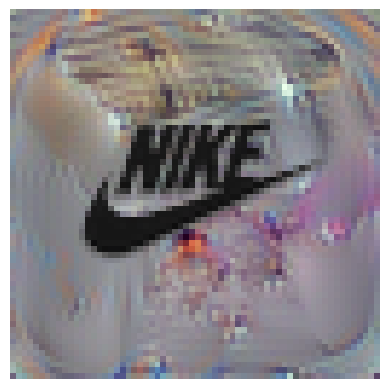

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# show the new patch
def show_combined_patch_with_matplotlib(patch_img):
    patch_img_np = np.array(patch_img)
    plt.imshow(patch_img_np)
    plt.axis('off')
    plt.show()

combined_patch_img = Image.open("patch_with_nike_logo.png")
show_combined_patch_with_matplotlib(combined_patch_img)



Repeat evaluation again with new patch

100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


New patch (with Nike logo) results:
Accuracy: 0.9415
Top-5 Accuracy: 0.9920


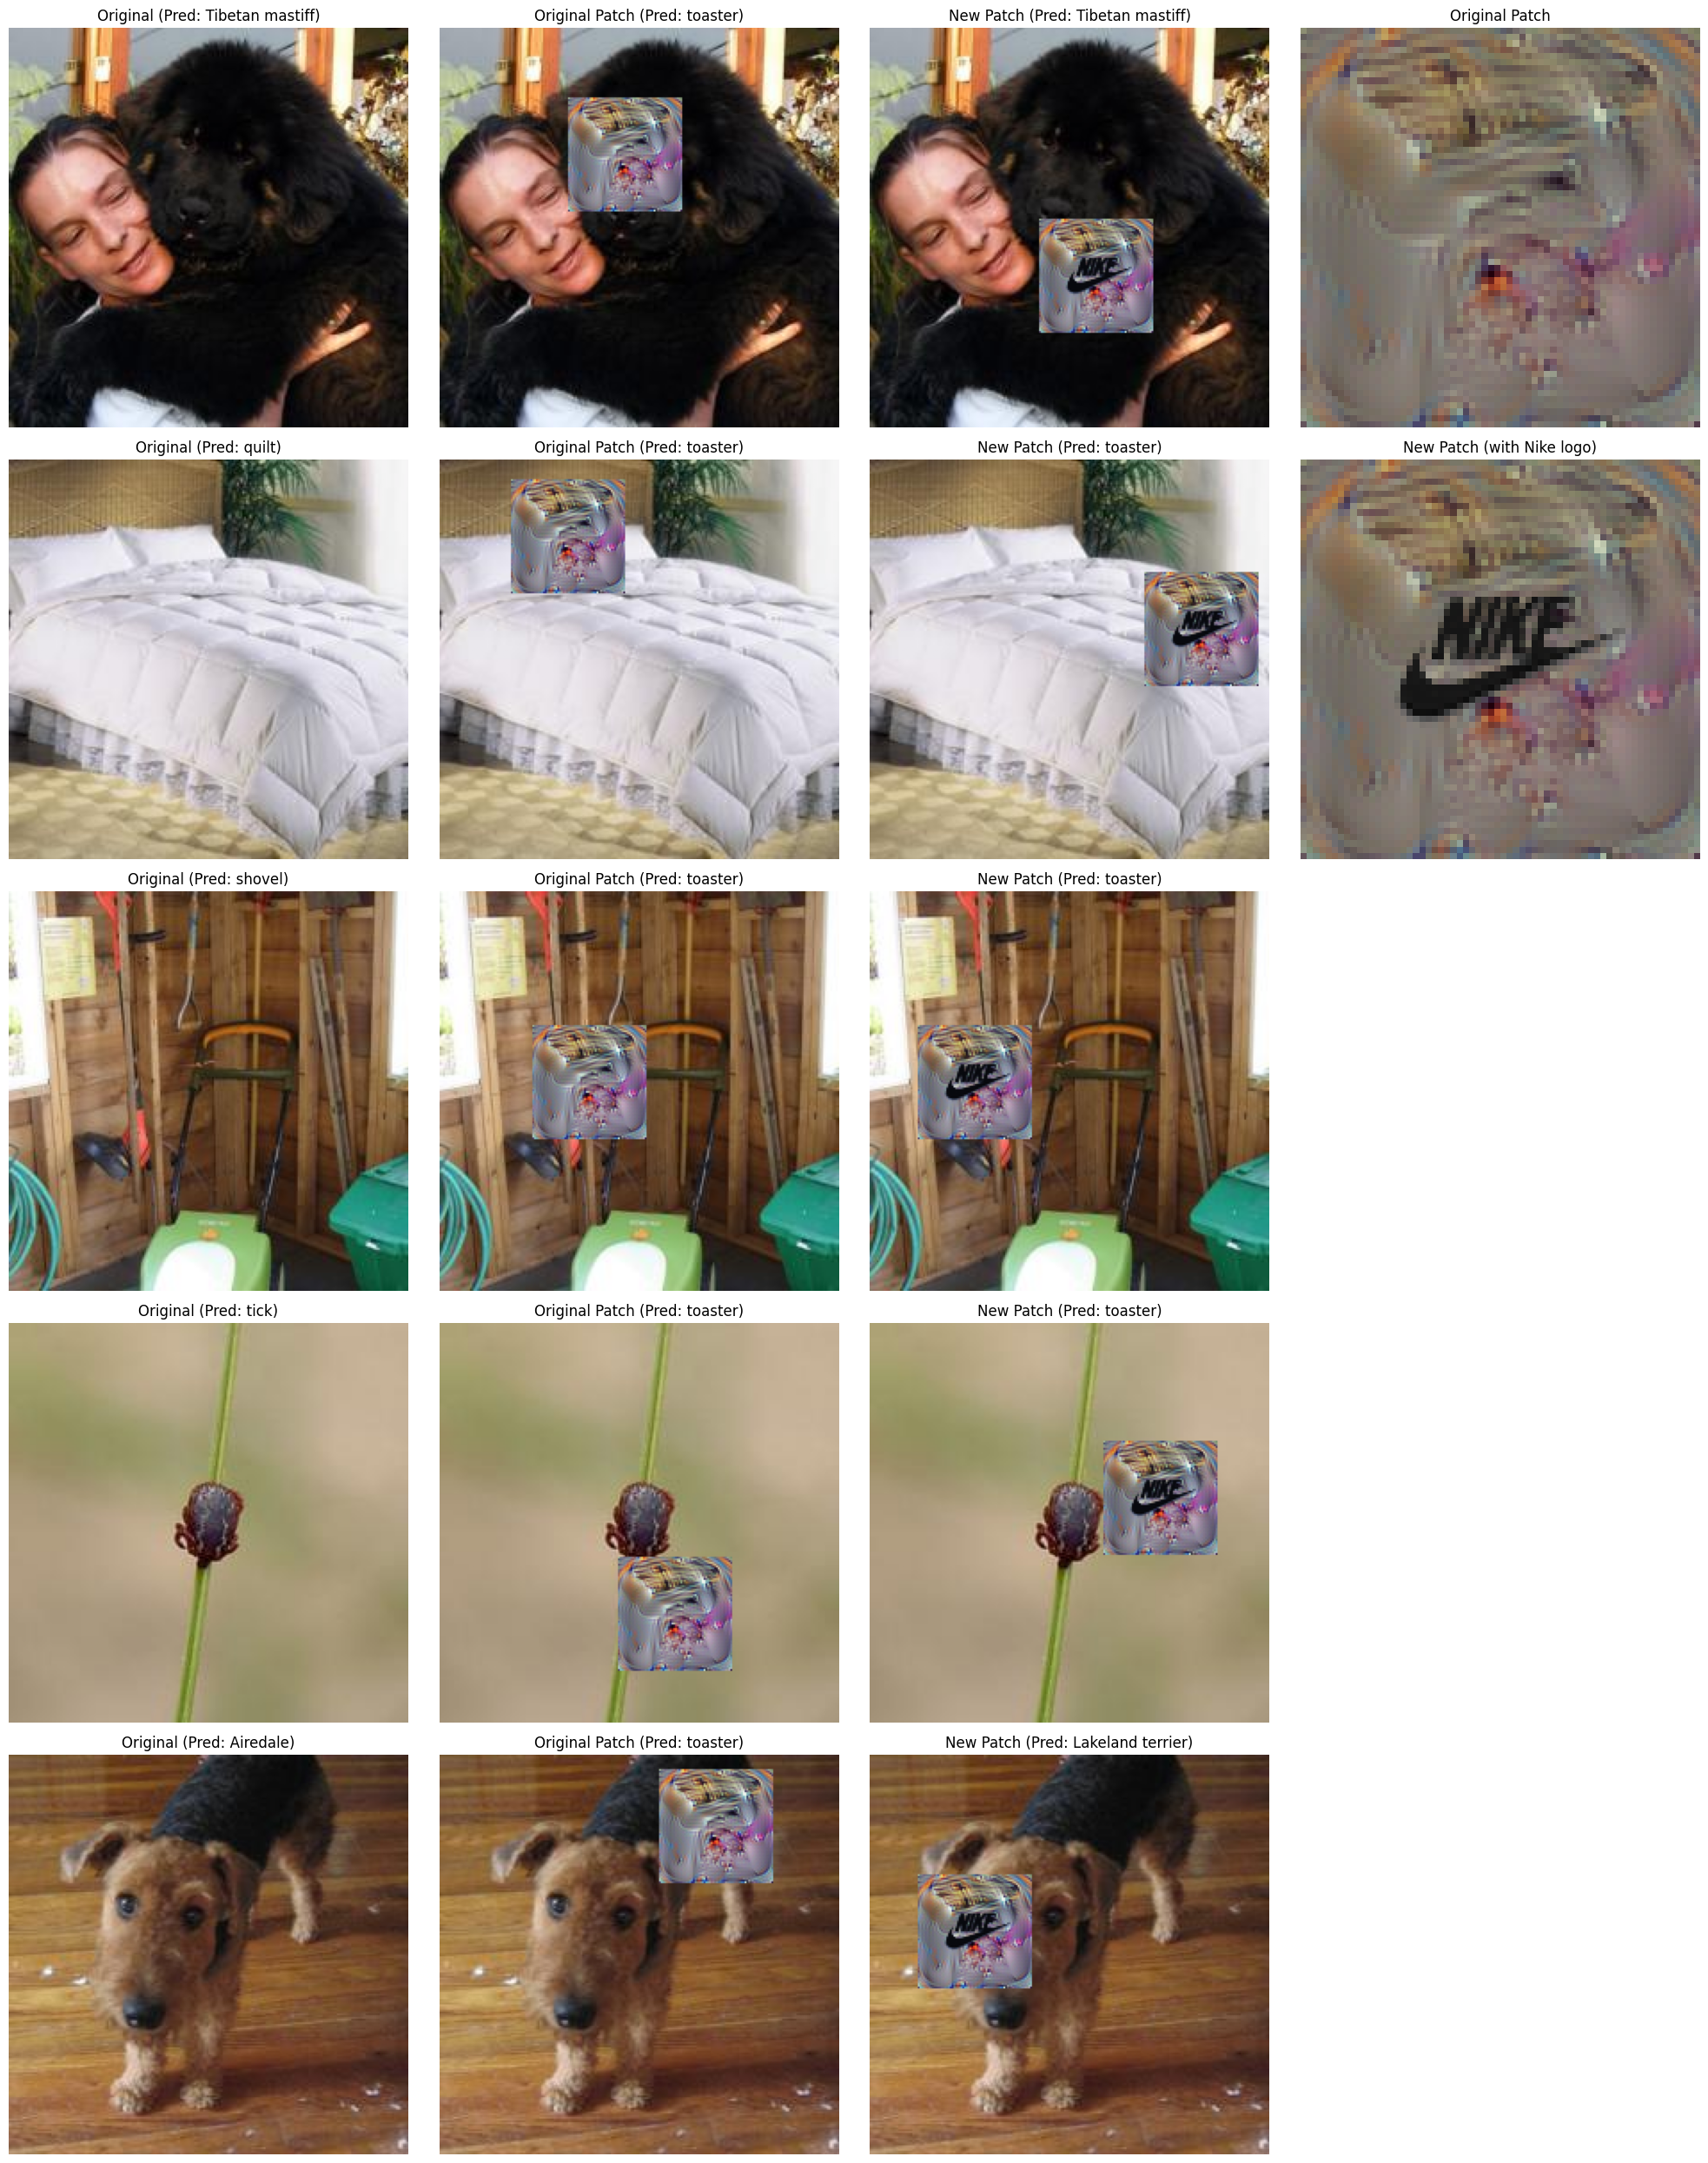

Patch with logo has been saved as patch_with_nike_logo.png


In [132]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights='IMAGENET1K_V1').to(device).eval()

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder("/content/AIPI-590/TinyImageNet", transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

TENSOR_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[:, None, None].to(device)
TENSOR_STD = torch.FloatTensor([0.229, 0.224, 0.225])[:, None, None].to(device)

def patch_forward(patch):
    return (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)

def place_patch(img, patch):
    if len(patch.shape) == 3:
        patch = patch.unsqueeze(0)
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[2])
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[3])
        img[i, :, h_offset:h_offset+patch.shape[2], w_offset:w_offset+patch.shape[3]] = patch_forward(patch)
    return img

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    patch = patch.to(device)
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader):
            img, img_labels = img.to(device), img_labels.to(device)
            for _ in range(4):
                patch_img = place_patch(img, patch)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    return tp / counter, tp_5 / counter

def tensor_to_image(tensor):
    tensor = tensor.squeeze().cpu().detach()
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return torch.clamp(tensor, 0, 1).permute(1, 2, 0).numpy()

def apply_logo_to_patch(patch, logo_image, logo_scale=0.7):
    patch_img = tensor_to_image(patch)
    patch_pil = Image.fromarray((patch_img * 255).astype(np.uint8))

    patch_width, patch_height = patch_pil.size
    logo_size = (int(patch_width * logo_scale), int(patch_height * logo_scale))
    logo_resized = logo_image.resize(logo_size, Image.LANCZOS).convert('RGBA')

    logo_layer = Image.new('RGBA', patch_pil.size, (0, 0, 0, 0))
    position = ((patch_width - logo_size[0]) // 2, (patch_height - logo_size[1]) // 2)
    logo_layer.paste(logo_resized, position, logo_resized)

    patch_rgba = patch_pil.convert('RGBA')
    return Image.alpha_composite(patch_rgba, logo_layer)

def pil_to_tensor(pil_image):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])(pil_image.convert('RGB')).unsqueeze(0)

# Load Nike Logo
logo_image_path = './AIPI-590/NikeLogo-removebg-preview.png'
logo_image = Image.open(logo_image_path)

# Apply logo to patch (assuming 'patch' is your trained adversarial patch)
patched_with_logo = apply_logo_to_patch(patch, logo_image, logo_scale=0.7)

# Convert back to tensor
new_patch_tensor = pil_to_tensor(patched_with_logo).to(device)

# Evaluate new patch
target_class = 859  # toaster class
new_acc, new_top5 = eval_patch(model, new_patch_tensor, val_loader, target_class)

print("New patch (with Nike logo) results:")
print(f"Accuracy: {new_acc.item():.4f}")
print(f"Top-5 Accuracy: {new_top5.item():.4f}")

# Load class names
with open("/content/AIPI-590/imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f.readlines()]

# Visualization function
def display_comparison(original_imgs, original_patched_imgs, new_patched_imgs, model, original_patch, new_patch, class_names, num_images=5):
    plt.figure(figsize=(20, num_images * 5))

    for i in range(num_images):
        original_pred = model(original_imgs[i].unsqueeze(0).to(device)).argmax(dim=1).item()
        original_patched_pred = model(original_patched_imgs[i].unsqueeze(0).to(device)).argmax(dim=1).item()
        new_patched_pred = model(new_patched_imgs[i].unsqueeze(0).to(device)).argmax(dim=1).item()

        plt.subplot(num_images, 4, i * 4 + 1)
        plt.title(f"Original (Pred: {class_names[original_pred]})")
        plt.imshow(tensor_to_image(original_imgs[i]))
        plt.axis('off')

        plt.subplot(num_images, 4, i * 4 + 2)
        plt.title(f"Original Patch (Pred: {class_names[original_patched_pred]})")
        plt.imshow(tensor_to_image(original_patched_imgs[i]))
        plt.axis('off')

        plt.subplot(num_images, 4, i * 4 + 3)
        plt.title(f"New Patch (Pred: {class_names[new_patched_pred]})")
        plt.imshow(tensor_to_image(new_patched_imgs[i]))
        plt.axis('off')

        if i == 0:
            plt.subplot(num_images, 4, 4)
            plt.title("Original Patch")
            plt.imshow(tensor_to_image(original_patch))
            plt.axis('off')

            plt.subplot(num_images, 4, 8)
            plt.title("New Patch (with Nike logo)")
            plt.imshow(tensor_to_image(new_patch))
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of images
images, _ = next(iter(val_loader))
images = images.to(device)

# Apply original patch and new patch
original_patched_images = place_patch(images.clone(), patch)
new_patched_images = place_patch(images.clone(), new_patch_tensor)

# Display comparison results
display_comparison(images, original_patched_images, new_patched_images, model, patch, new_patch_tensor, class_names, num_images=5)

# Save the patch with logo
patched_with_logo.save('patch_with_nike_logo.png')
print("Patch with logo has been saved as patch_with_nike_logo.png")